In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error



data = pd.read_excel("/Users/rohanshenoy/Downloads/yahoo_data.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data=data.sort_values(by="Date",ascending=True)
data.set_index("Date",inplace=True)
data.head()

,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,
2018-05-01,24117.29,24117.29,23808.19,24099.05,24099.05,380070000
2018-05-02,24097.63,24185.52,23886.30,23924.98,23924.98,385350000
2018-05-03,23836.23,23996.15,23531.31,23930.15,23930.15,389240000
2018-05-04,23865.22,24333.35,23778.87,24262.51,24262.51,329480000
2018-05-07,24317.66,24479.45,24263.42,24357.32,24357.32,307670000


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2018-05-01 to 2023-04-28
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         1258 non-null   float64
 1   High         1258 non-null   float64
 2   Low          1258 non-null   float64
 3   Close*       1258 non-null   float64
 4   Adj Close**  1258 non-null   float64
 5   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


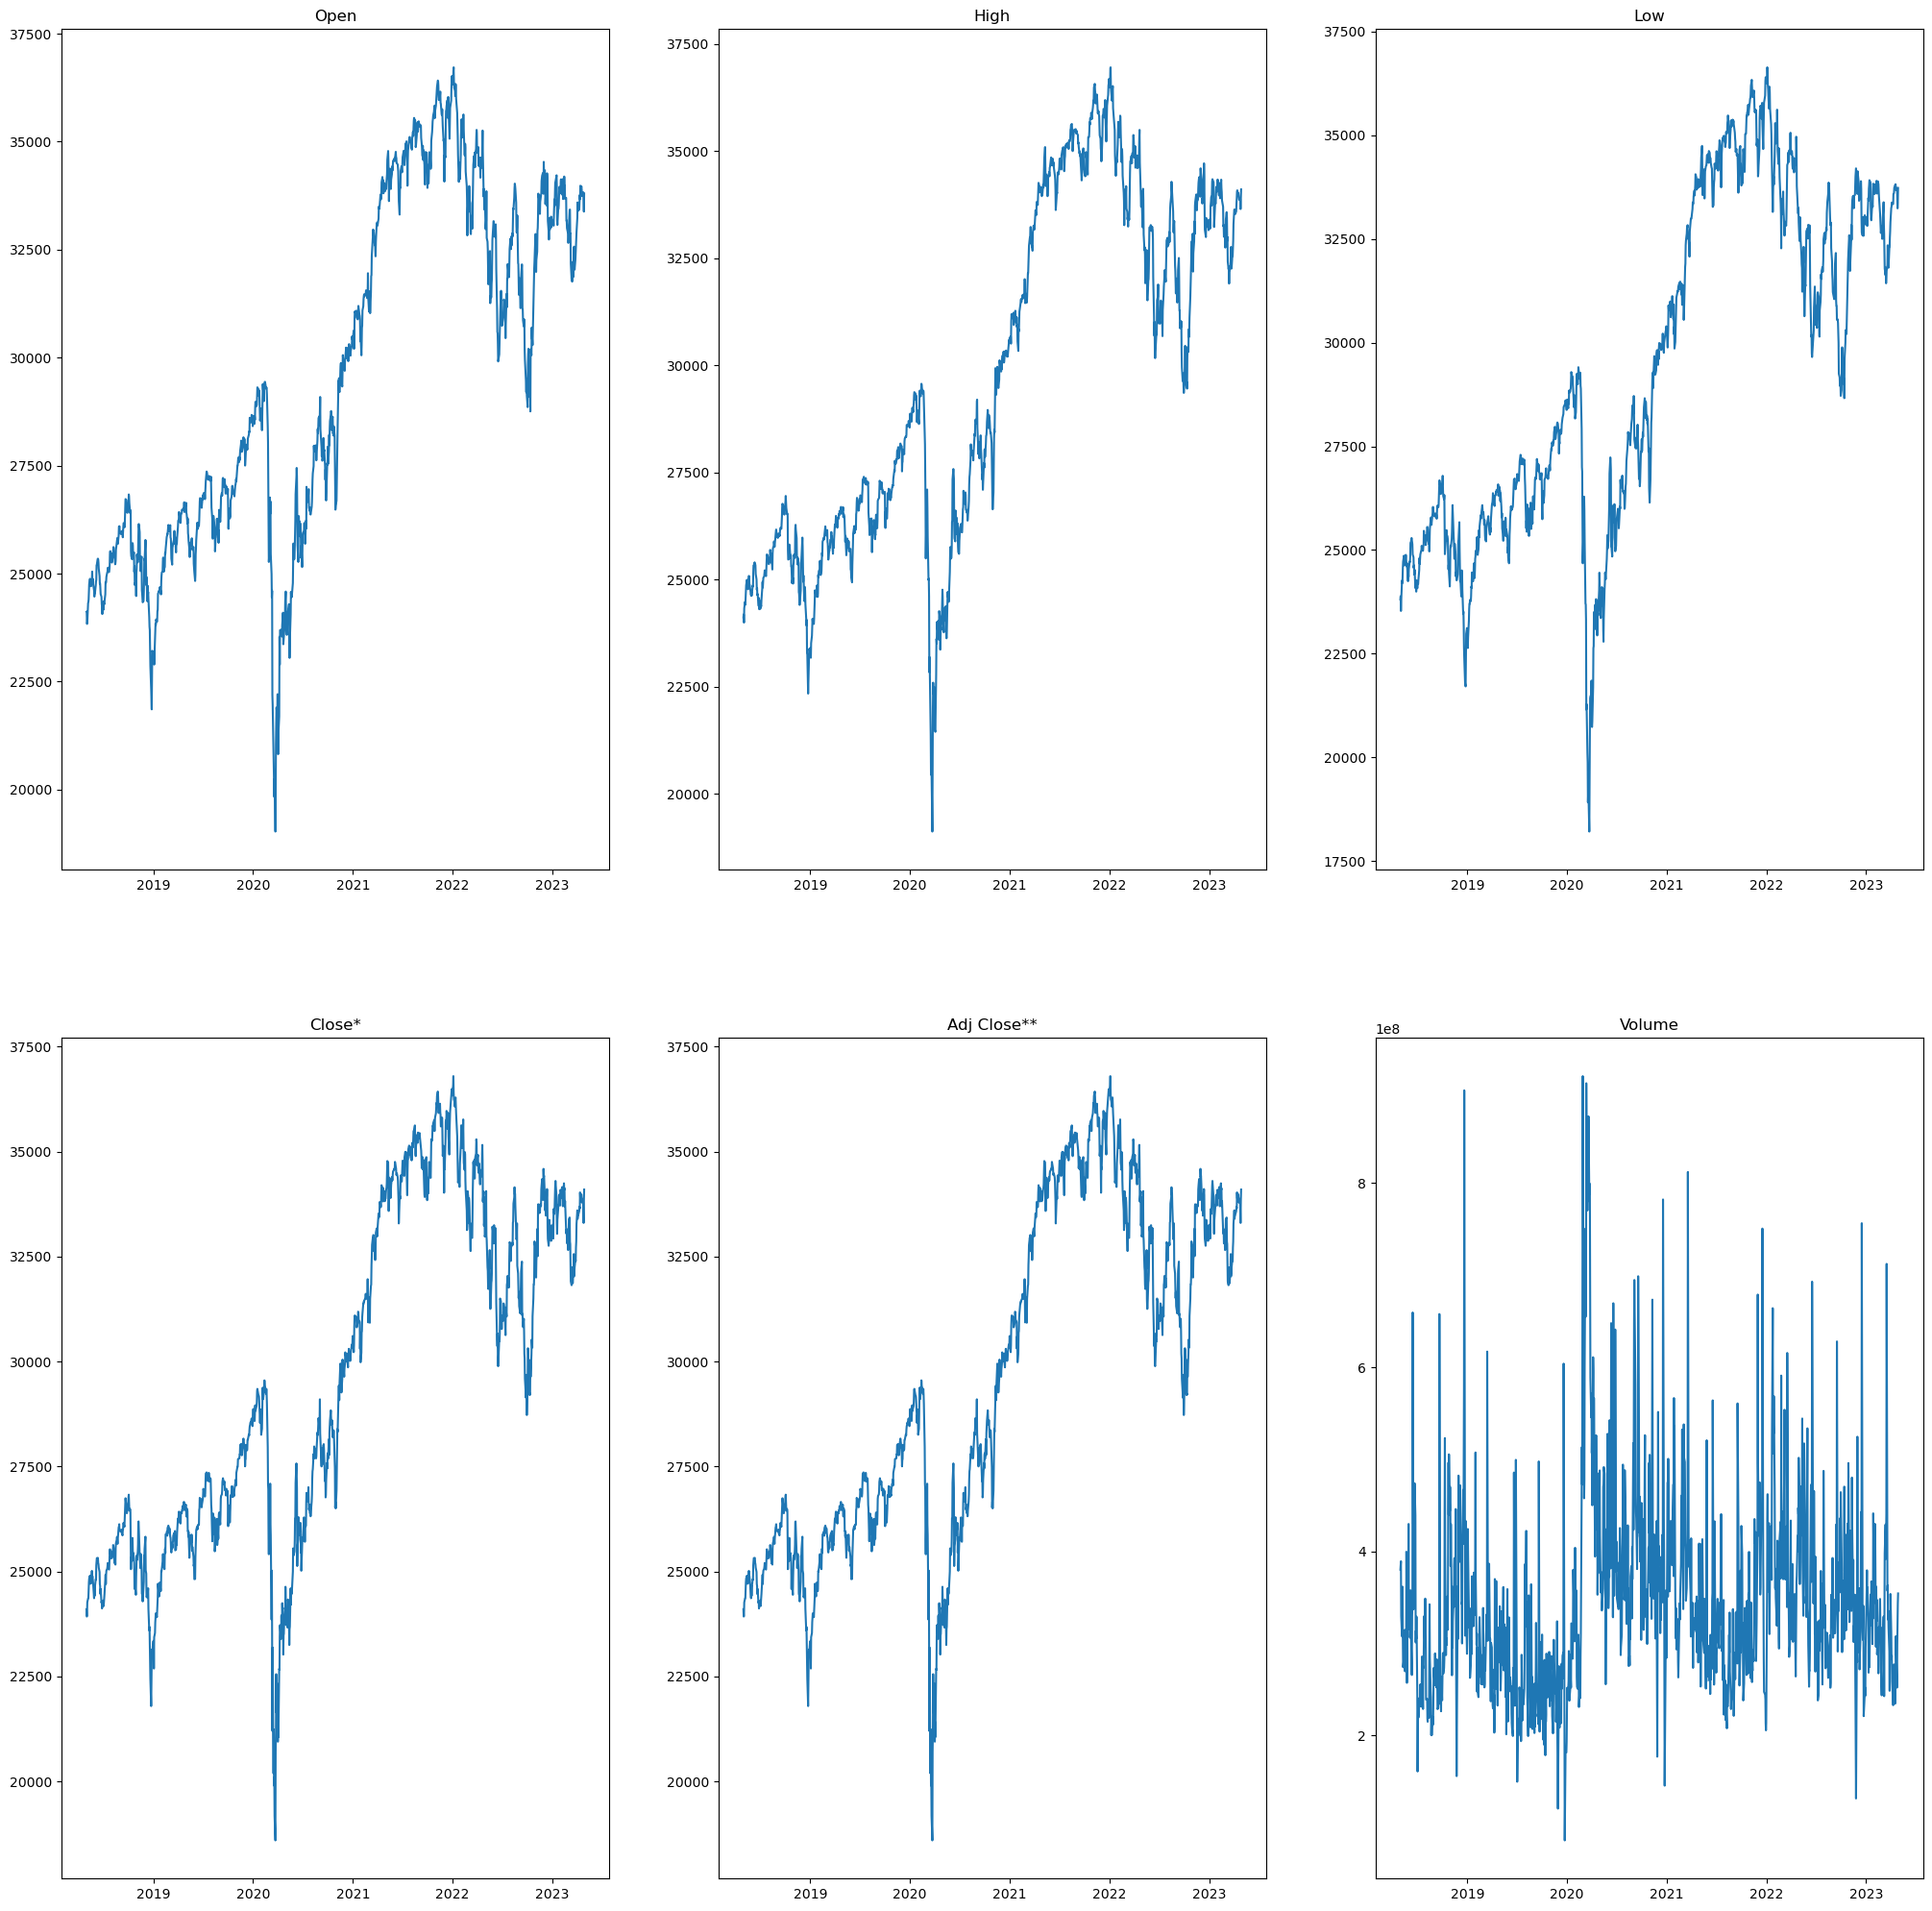

In [3]:
fig = plt.figure(figsize=(25,25))
i=1
for x in data.columns :
    plt.subplot(2,3,i)
    ax=sns.lineplot(data[x])
    ax.set(xlabel=None)
    plt.title(str(x), loc='center')
    plt.xlabel(None)
    plt.ylabel(None)
    i+=1
plt.show()


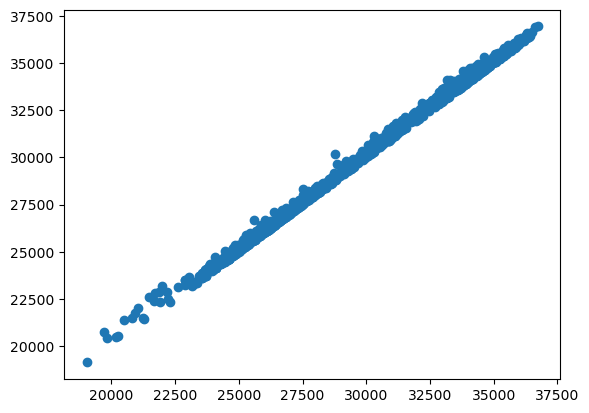

In [4]:
plt.scatter(data=data,x="Open",y="High")


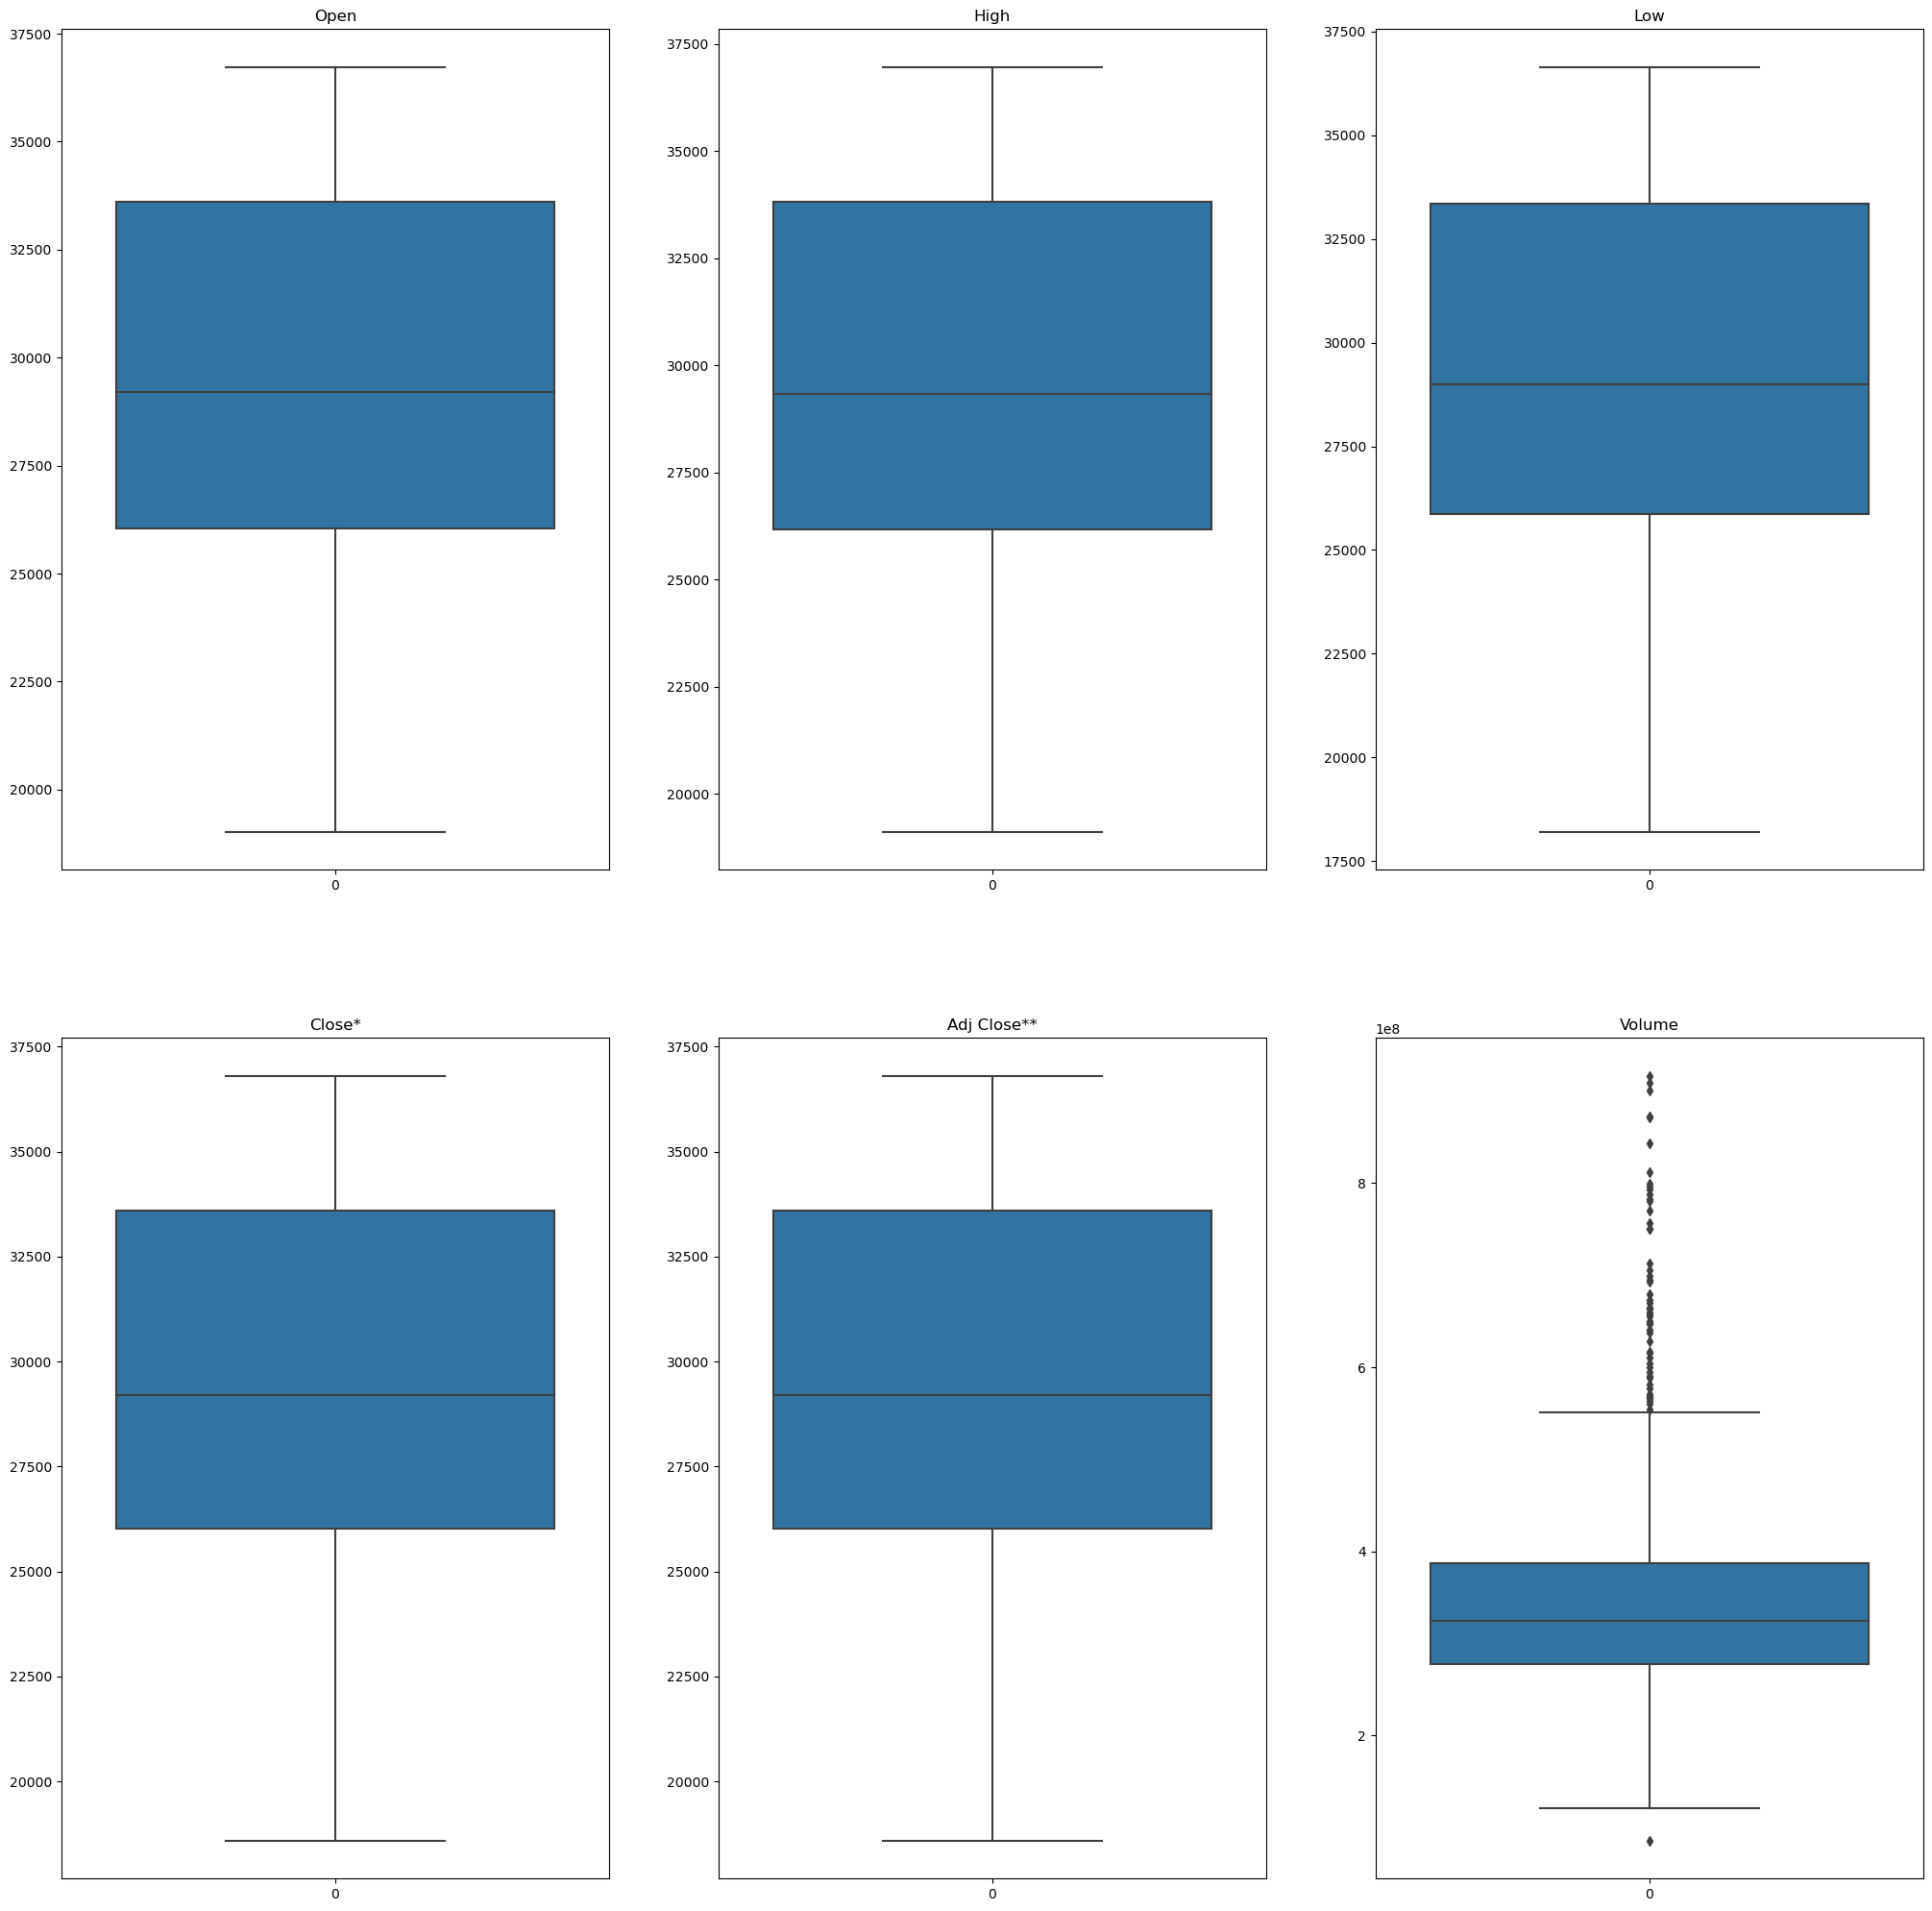

In [5]:
fig = plt.figure(figsize=(25,25))
i=1
for x in data.columns :
    plt.subplot(2,3,i)
    ax=sns.boxplot(data[x])
    ax.set(xlabel=None)
    plt.title(str(x), loc='center')
    plt.xlabel(None)
    plt.ylabel(None)
    i+=1
plt.show()


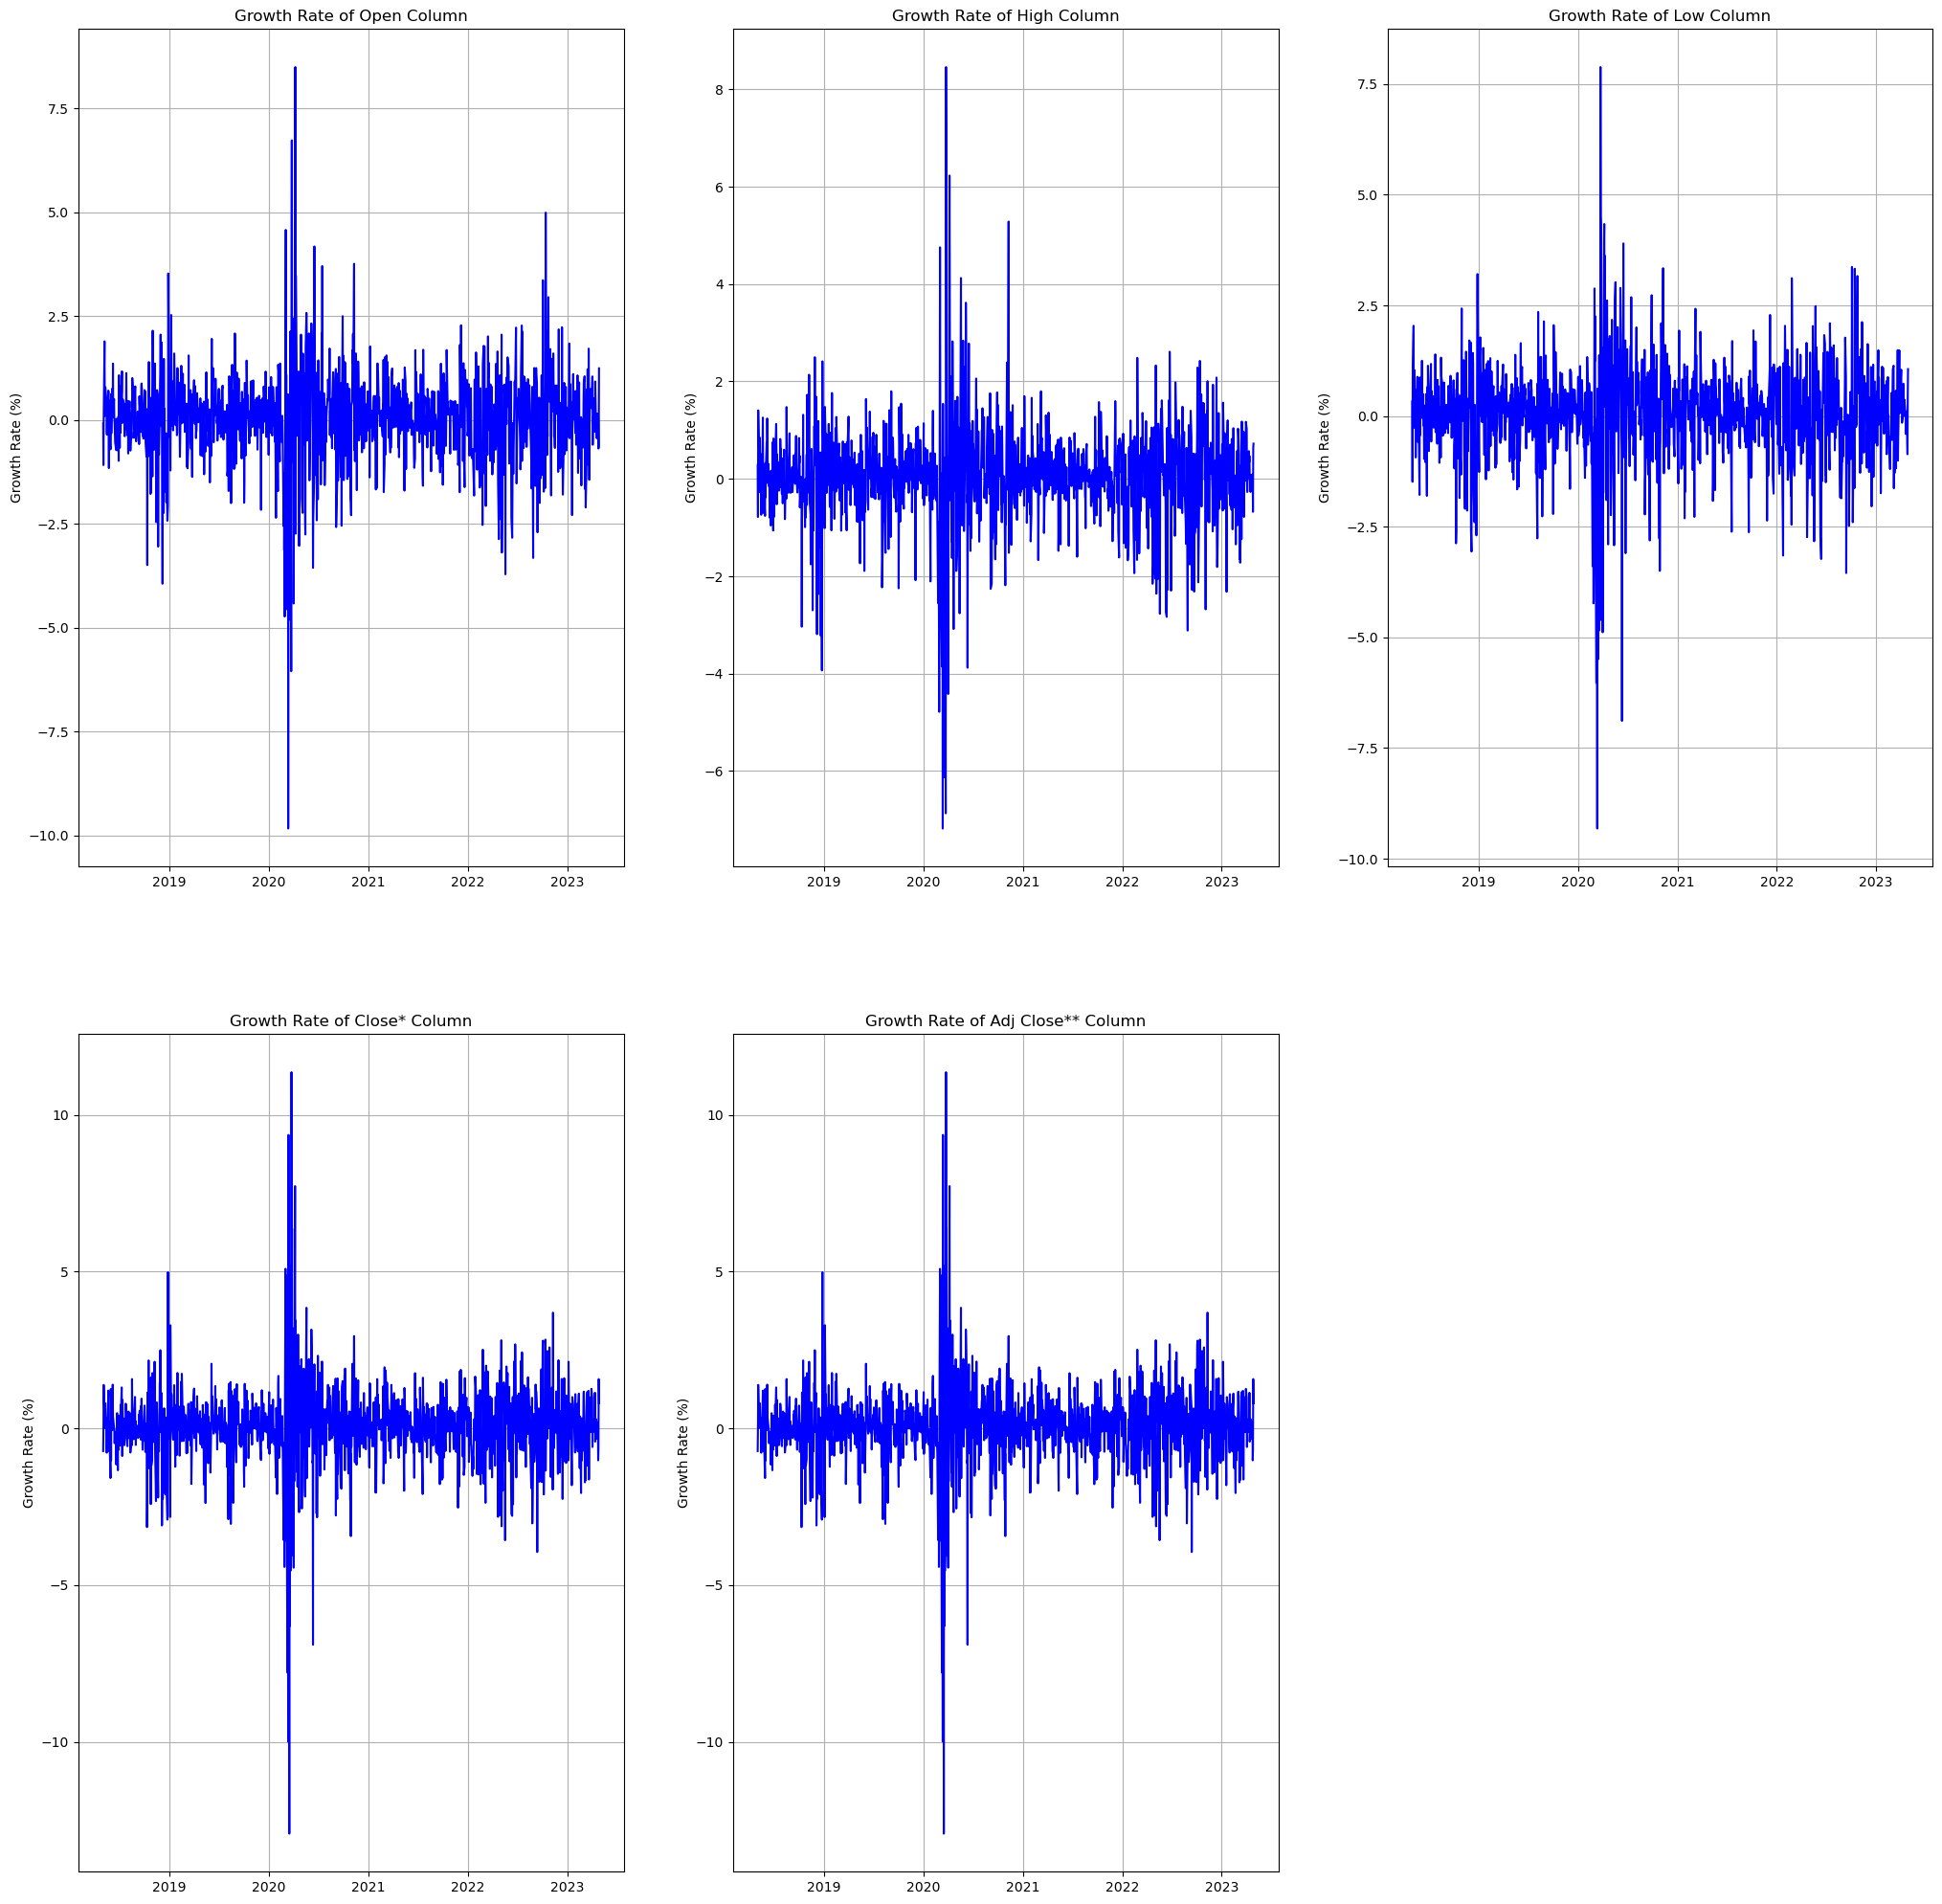

In [6]:
plt.figure(figsize=(25,25))
i=1
for x in data.columns[:-1]:
    plt.subplot(2,3,i)
    data['Growth Rate'] = (data[x] - data[x].shift(1)) / data[x].shift(1) * 100
    plt.plot(data.index, data['Growth Rate'], linestyle='-', color='b')
    plt.xlabel(None)
    plt.ylabel('Growth Rate (%)')
    plt.title(f'Growth Rate of {x} Column')
    plt.grid(True)
    i+=1
plt.show()

In [7]:

scaler = MinMaxScaler()
data['Adj Close**'] = scaler.fit_transform(data[['Adj Close**']])

In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back)])
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [9]:
split_idx = int(len(data) * 0.8)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

trainX, trainY = create_dataset(train_data['Adj Close**'].values, 30)
testX, testY = create_dataset(test_data['Adj Close**'].values, 30)

In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [11]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(30, 1)))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(trainX, trainY, epochs=50, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
31/31 [==============================] - 1s 8ms/step - loss: 0.0851
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6/50
31/31 [===

In [12]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape(-1, 1))

7/7 [==============================] - 0s 2ms/step


In [13]:
rmse = np.sqrt(mean_squared_error(testY, testPredict))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 516.4228075916866


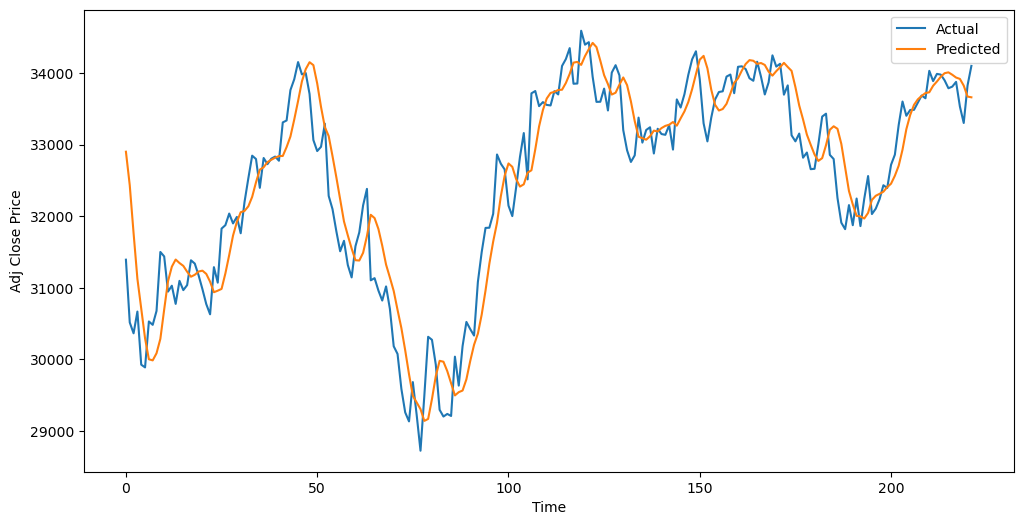

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(testY, label='Actual')
plt.plot(testPredict, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()